## Import MIGraphX Python Library

References:<br>
https://github.com/naomifridman/Unet_Brain_tumor_segmentation

In [1]:
import migraphx
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

## Fetch U-NET ONNX Model

In [2]:
!wget -nc https://zenodo.org/record/3928973/files/224_224_160_dyanmic_bs.onnx

File ‘224_224_160_dyanmic_bs.onnx’ already there; not retrieving.



## Load ONNX Model

In [3]:
model = migraphx.parse_onnx("224_224_160_dyanmic_bs.onnx")

In [4]:
model.compile(migraphx.get_target("gpu"))

## Print model parameters

In [5]:
print(model.get_parameter_names())
print(model.get_parameter_shapes())

['input']
{'input': float_type, {1, 4, 224, 224, 160}, {32112640, 8028160, 35840, 160, 1}}


In [6]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [7]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [8]:
import pandas as pd
import numpy as np
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random

In [9]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [10]:
from importlib import reload  # Python 3.4+ only.

In [11]:
import visualization_utils  as vu
reload(vu)

<module 'visualization_utils' from '/code/AMDMIGraphX/AMDMIGraphX/examples/python_unet/visualization_utils.py'>

In [30]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);


In [31]:
def read_img_sitk(img):
    inputImage = sitk.ReadImage( img )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    image = sitk.GetArrayFromImage(inputImage)
    return image

In [32]:
# ima files are of the form
# BraTS19_TCIA04_192_1_flair.nii.gz  
# BraTS19_TCIA04_192_1_t1.nii.gz    
# BraTS19_TCIA04_192_1_t2.nii.gz
# BraTS19_TCIA04_192_1_seg.nii.gz    
# BraTS19_TCIA04_192_1_t1ce.nii.gz

def read_image_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((4, 160, 224, 224), dtype=np.float32)
    
    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii')
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_sitk(flair_img)
        
    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_sitk(t1_img)
    else:
        np_image[1] = read_img_sitk(t1_nb4_img)    
            
    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_sitk(t1ce_img)
    else:
        np_image[2] = read_img_sitk(t1ce_nb4_img)    
    
        
    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_sitk(t2_img)

    return np_image

In [33]:
def read_lable_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((160, 224, 224), dtype=np.int)
    
    ## lable
    lable_img = os.path.join(dirpath, img_id+'_seg.nii')
    if (not os.path.isfile(lable_img)):
        print(lable_img,' not found aborting')
        return None
    np_image = read_img_sitk(lable_img).astype(int)

    return np_image

In [34]:
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return [rmin, rmax, cmin, cmax, zmin, zmax]

Multiple image inputs:
- Native (T1)
- Post-contrast T1-weighted (T1Gd)
- T2-weighted (T2)
- T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

In [50]:
np_img = read_image_into_numpy('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled/BraTS19_2013_10_1')
np_img = read_image_into_numpy('/code/AMDMIGraphX/sampleData/LGG/BraTS19_TCIA10_202_1')
np_img.shape

ValueError: could not broadcast input array from shape (155,240,240) into shape (160,224,224)

<Figure size 432x360 with 0 Axes>

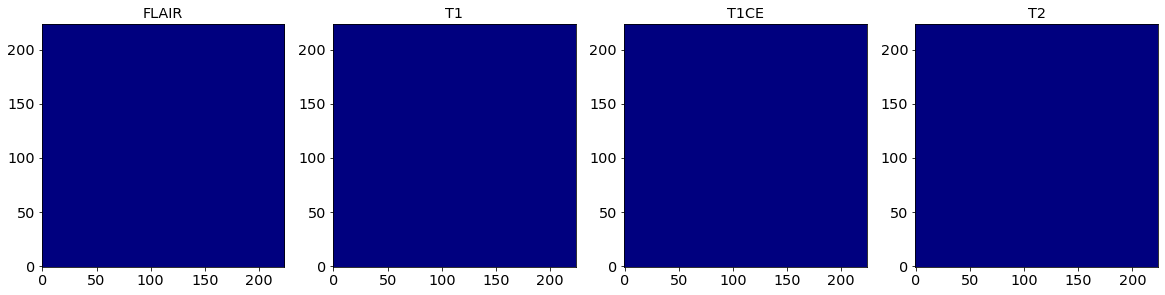

In [49]:
vu.show_n_images(np_img[:,100,:,:], titles=img_type)

<Figure size 432x360 with 0 Axes>

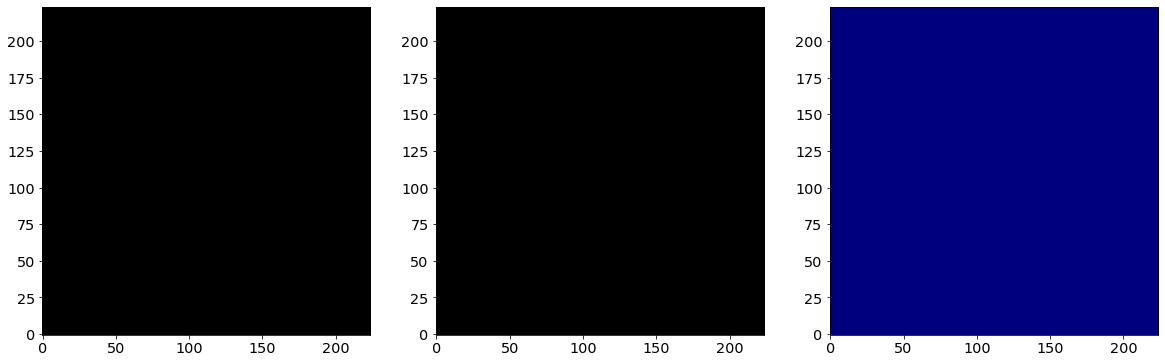

In [37]:
np_lbl = read_lable_into_numpy('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled/BraTS19_2013_10_1')
np_lbl.shape
img1 = vu.show_lable_on_image4(np_img[1,100,:,:], np_lbl[100])
img2 = vu.show_lable_on_image(np_img[1,100,:,:], np_lbl[100])
vu.show_n_images([img1,img2,np_img[0,100]])

In [25]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

def get_prediction_for_batch(pred_batch, threshold=0.5):
    
    out_batch = np.zeros((pred_batch.shape[0], 240, 240),dtype=np.int)
    
    for j in range(pred_batch.shape[0]):
        pred = get_prediction(pred_batch[j])
        if (pred.sum()>0):
            print(j, np.unique(pred , return_counts=True))
        out_batch[j] = lbl_from_cat(get_prediction(pred_batch[j]))
    return out_batch

def get_label_from_pred_batch(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 224, 224), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,0])+\
                get_pred(labels_batch[j,:,:,1])*2+\
        get_pred(labels_batch[j,:,:,2])*4

    return batch

def predict_3D_img_prob(np_file):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((160, 224, 224, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img


In [42]:
def resample(data):
    dimension = data.GetDimension()
    print(dimension)
    print(data.GetSize())
    print(data.GetSpacing())

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)
    #for img in data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(data.GetSize(), data.GetSpacing(), reference_physical_size)]
    
    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()
    
    # Select arbitrary number of pixels per dimension, smallest size that yields desired results 
    # or the required size of a pretrained network (e.g. VGG-16 224x224), transfer learning. This will 
    # often result in non-isotropic pixel spacing.
    reference_size = [224,224,160]
    reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]
    
    # Another possibility is that you want isotropic pixels, then you can specify the image size for one of
    # the axes and the others are determined by this choice. Below we choose to set the x axis to 128 and the
    # spacing set accordingly. 
    # Uncomment the following lines to use this strategy.
    #reference_size_x = 128
    #reference_spacing = [reference_physical_size[0]/(reference_size_x-1)]*dimension
    #reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]
    
    reference_image = sitk.Image(reference_size, data.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    
    # Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as 
    # this takes into account size, spacing and direction cosines. For the vast majority of images the direction 
    # cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the 
    # spacing will not yield the correct coordinates resulting in a long debugging session. 
    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_image
    
inputImage = sitk.ReadImage('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii')
#inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
resampledImage = resample(inputImage)
sitk.WriteImage(resampledImage, '/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii')

inputImage = sitk.ReadImage('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii')
#inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
resampledImage = resample(inputImage)
sitk.WriteImage(resampledImage, '/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii')

inputImage = sitk.ReadImage('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii')
#inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
resampledImage = resample(inputImage)
sitk.WriteImage(resampledImage, '/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii')

inputImage = sitk.ReadImage('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii')
#inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
resampledImage = resample(inputImage)
sitk.WriteImage(resampledImage, '/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii')

inputImage = sitk.ReadImage('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii')
#inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
resampledImage = resample(inputImage)
sitk.WriteImage(resampledImage, '/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii')

3
(240, 240, 155)
(1.0, 1.0, 1.0)
3
(240, 240, 155)
(1.0, 1.0, 1.0)
3
(240, 240, 155)
(1.0, 1.0, 1.0)
3
(240, 240, 155)
(1.0, 1.0, 1.0)
3
(240, 240, 155)
(1.0, 1.0, 1.0)


In [ ]:
#np_img and np_lbl have the image data and label data in numpy
np_img = read_image_into_numpy('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled')
print(np_img.shape)
print(np_img.strides)
np_lbl = read_lable_into_numpy('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1/resampled')
print(np_lbl.shape)

assert(np_lbl[np_lbl==3].sum()==0)
np_lbl = np.where(np_lbl==4, 3, np_lbl)
print(np_lbl.shape)

#Remember the MIGraphX model inputs
print(model.get_parameter_names())
print(model.get_parameter_shapes())

#np_img = np.expand_dims(np_img, 0)
print(np_img.shape)
print(np_img.strides)

input_im = np.zeros((1,4,224,224,160),dtype='float32') 
np.lib.stride_tricks.as_strided(input_im, shape=np_img.shape, strides=input_im.strides)[:] = np_img #getting correct stride
print(input_im.strides)
print(input_im.shape)

result = model.run({
         "input": input_im
     })